In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set(style='whitegrid')
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Load the data
df = pd.read_csv('housing.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


In [5]:
from sklearn.neighbors import KNeighborsRegressor
# function that imputes a dataframe 
def impute_knn(df):
    
    ''' inputs: pandas df containing feature matrix '''
    ''' outputs: dataframe with NaN imputed '''
    # imputation with KNN unsupervised method

    # separate dataframe into numerical/categorical
    ldf = df.select_dtypes(include=[np.number])           # select numerical columns in df
    ldf_putaside = df.select_dtypes(exclude=[np.number])  # select categorical columns in df
    # define columns w/ and w/o missing data
    cols_nan = ldf.columns[ldf.isna().any()].tolist()         # columns w/ nan 
    cols_no_nan = ldf.columns.difference(cols_nan).values     # columns w/o nan 

    for col in cols_nan:                
        imp_test = ldf[ldf[col].isna()]   # indicies which have missing data will become our test set
        imp_train = ldf.dropna()          # all indicies which which have no missing data 
        model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ldf.loc[df[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ldf,ldf_putaside],axis=1)

In [6]:
df2 = impute_knn(df)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


- some terminology:
  as far as ik, independent variable, predictor, feature, covariate, regressor, explanatory variable are used synonymously. same with dependent variable, response variable, etc.
  
- univariate histograms allow you to look at the distributinos of each variable individually
- just point out the obvious stuff, like outliers (odd peaks/spikes), which could be because of how the data was sampled. A lot of the data distributions are skewed (de-centralized) which tells us that we should standardize the data before modelling it
- outliers and gaps in the distribution may be due to how the data was sampled like for median_age

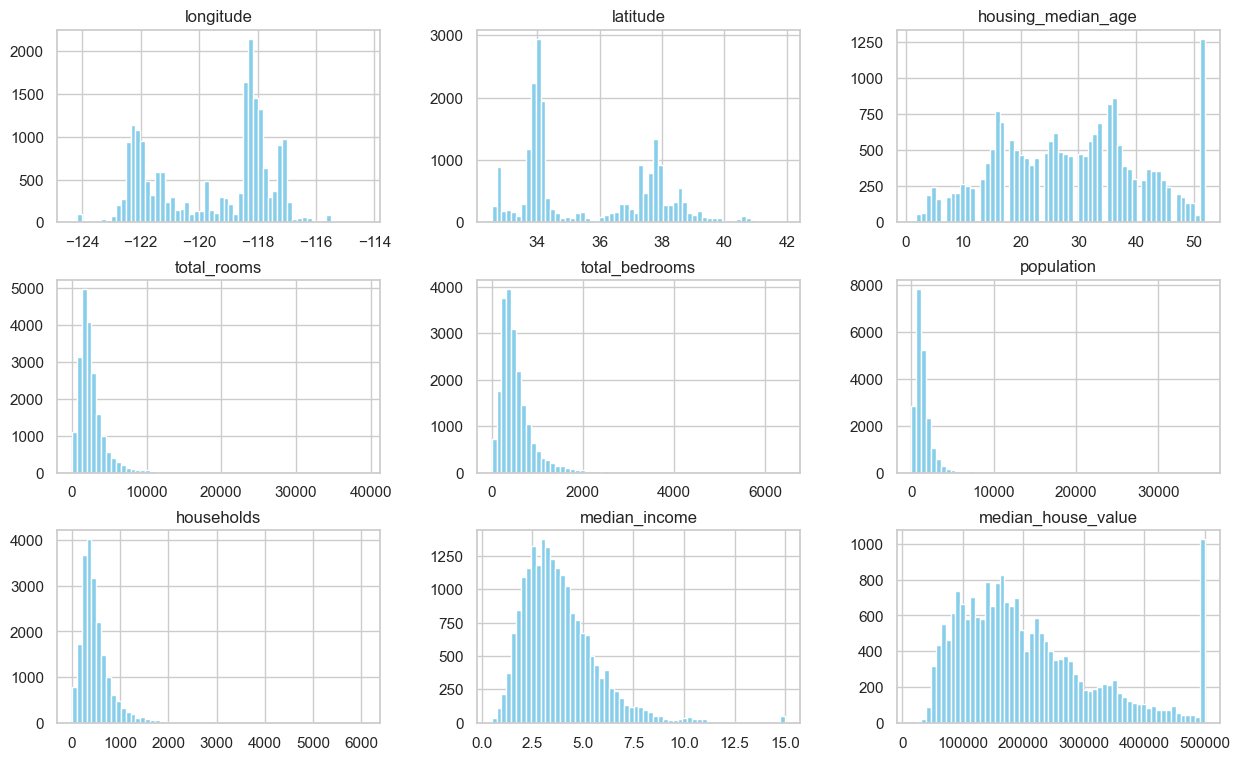

In [7]:
# univariate histograms (look at the distributions of each variable individually)
df2.hist(bins=60, figsize=(15,9),color='skyblue');plt.show()

- a bivariate correlation matrix contains only information about the linear similarity of two feature relation
- useful b/c too highly or too lowly correlated features should be dropped and we want to identify them
- thus, we wanna look for any signs of nonlinearity in the dataset, such as a fair few low linear correlation values
- high correlation values between multiple features could indicate that features may represent similar things
- Target (response) variable median_house_value is very mildly correlated to all but one feature here: median_income, so one might outline this as an important feature.
- A correlation of -0.02 & -0.05 (population/longitude) to the target variable median_house_value might be worth dropping, but they might not be. In fact, a low value isn't exactly a reason to drop a feature. It could simply imply the data is spread quite a lot, which is a strong indicator of nonlinearity.

In [8]:
''' Function to plot correlation of features '''
def corrMat(df,id=False):
    
    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(6,6))
    mask = np.zeros_like(corr_mat,dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0, 
                cmap='YlGnBu',square=False,lw=2,annot=True,cbar=False);plt.show()  

In [10]:
''' Draw a Bivariate Seaborn Pairgrid /w KDE density w/ '''
def snsPairGrid(df):

    ''' Plots a Seaborn Pairgrid w/ KDE & scatter plot of df features'''
    g = sns.PairGrid(df,diag_sharey=False)
    g.fig.set_size_inches(14,13)
    g.map_diag(sns.kdeplot, lw=2) # draw kde approximation on the diagonal
    g.map_lower(sns.scatterplot,s=15,edgecolor="k",linewidth=1,alpha=0.4) # scattered plot on lower half
    g.map_lower(sns.kdeplot,cmap='YlGnBu',n_levels=10) # kde approximation on lower half
    plt.tight_layout()

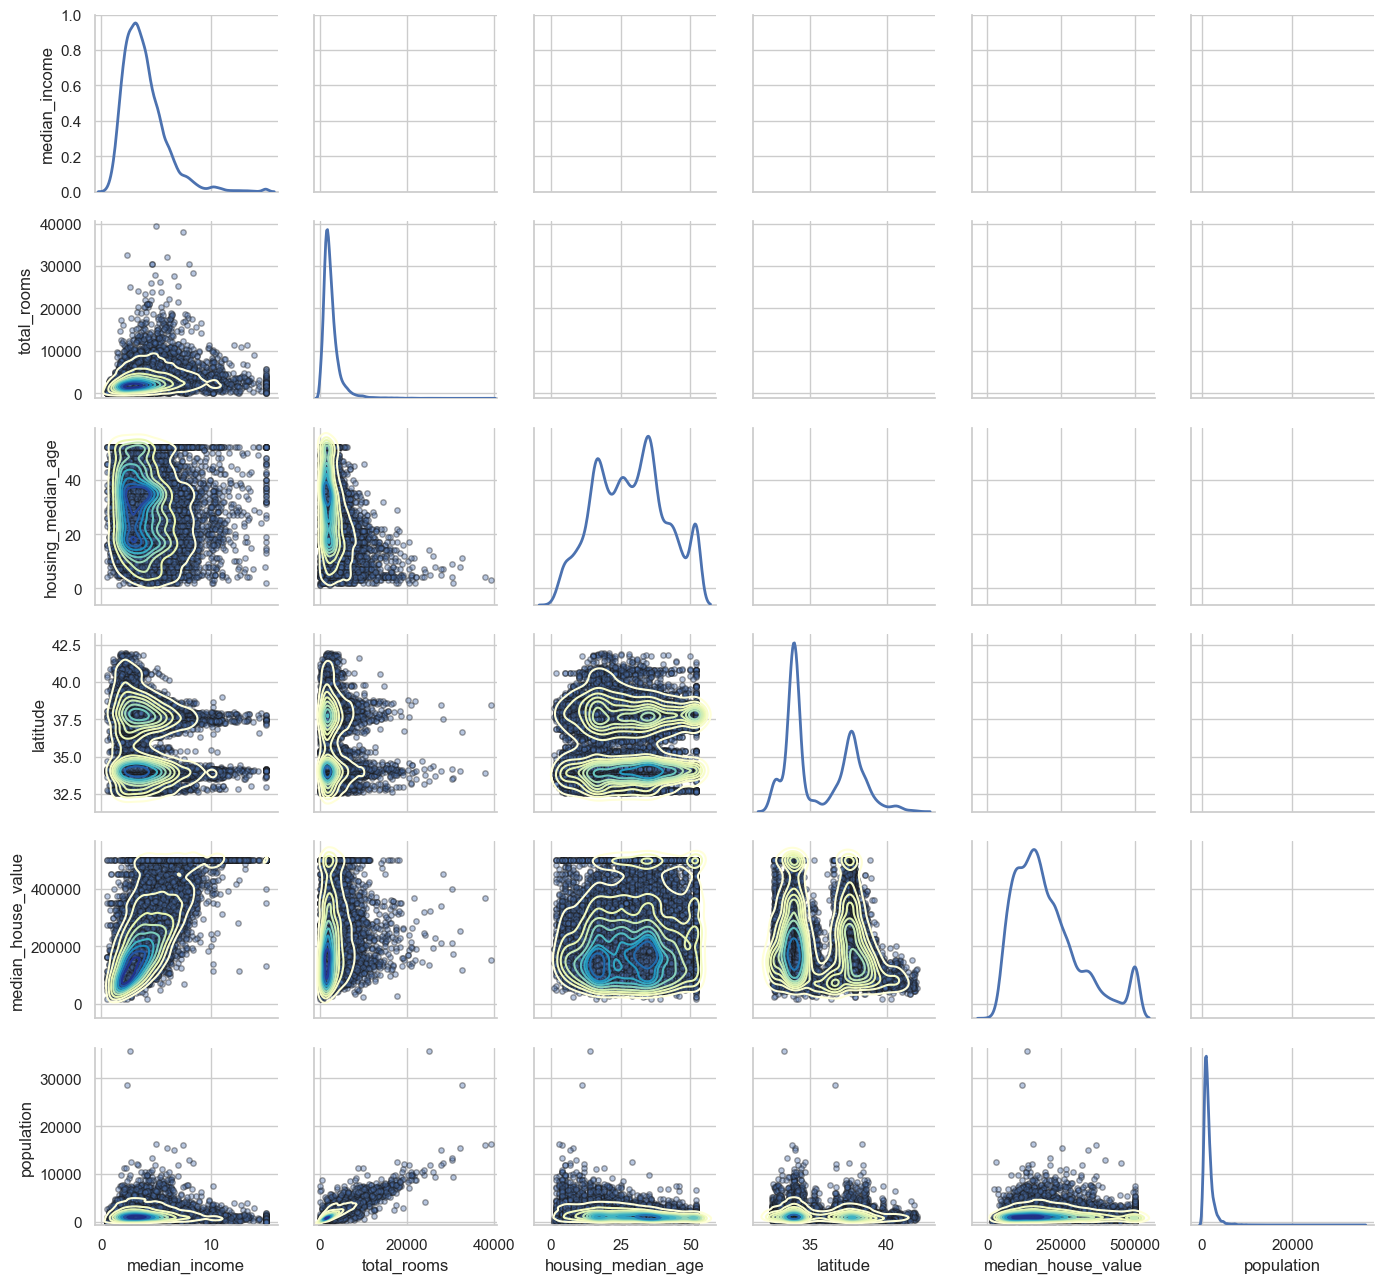

In [11]:
tlist = ['median_income','total_rooms','housing_median_age','latitude','median_house_value','population']
snsPairGrid(df2[tlist]) 

In [12]:
''' Plot Two Geopandas Plots Side by Side '''
# defining a simple plot function, input list containing features of names found in dataframe
def plotTwo(df,lst):
    
    # load california from module, common for all plots
    cali = gpd.read_file(gplt.datasets.get_path('california_congressional_districts'))
    cali = cali.assign(area=cali.geometry.area)
    
    # Create a geopandas geometry feature; input dataframe should contain .longtitude, .latitude
    gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude,df.latitude))
    proj=gcrs.AlbersEqualArea(central_latitude=37.16611, central_longitude=-119.44944) # related to view

    ii=-1
    fig,ax = plt.subplots(1,2,figsize=(21,6),subplot_kw={'projection': proj})
    for i in lst:

        ii+=1
        tgdf = gdf.sort_values(by=i,ascending=True) 
        gplt.polyplot(cali,projection=proj,ax=ax[ii]) # the module already has california 
        gplt.pointplot(tgdf,ax=ax[ii],hue=i,cmap='plasma',legend=True,alpha=1.0,s=3) # 
        ax[ii].set_title(i)

    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.5)

/var/folders/39/dz75516n3x3cb69nvg9vnwqr0000gn/T/ipykernel_74272/2016133750.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cali = cali.assign(area=cali.geometry.area)
/var/folders/39/dz75516n3x3cb69nvg9vnwqr0000gn/T/ipykernel_74272/2016133750.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cali = cali.assign(area=cali.geometry.area)


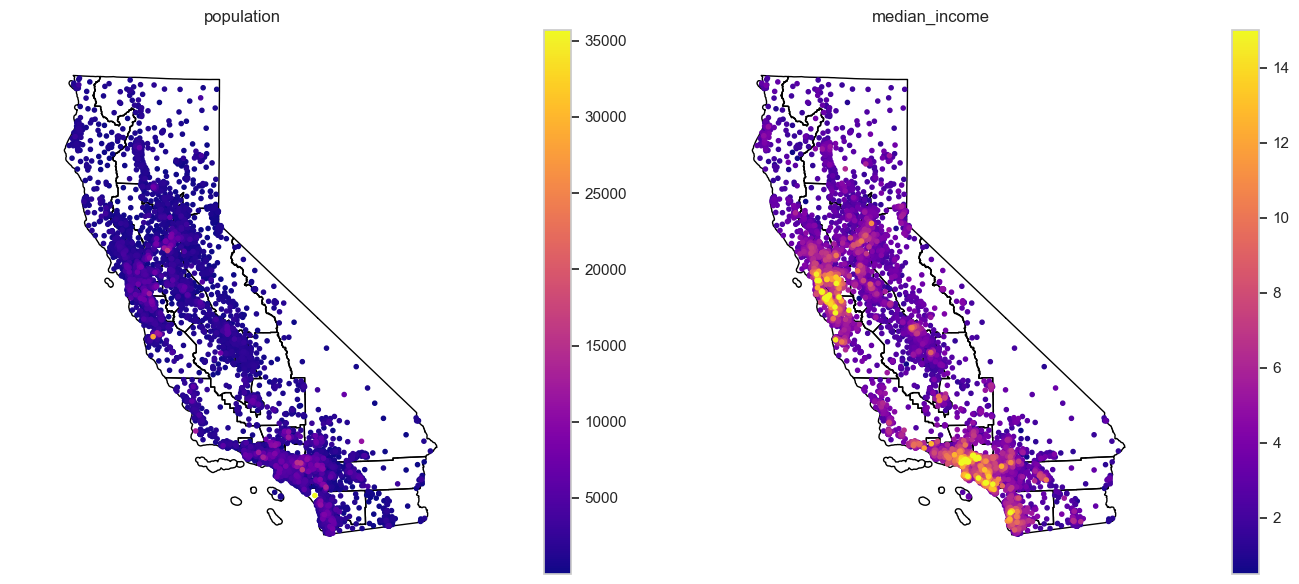

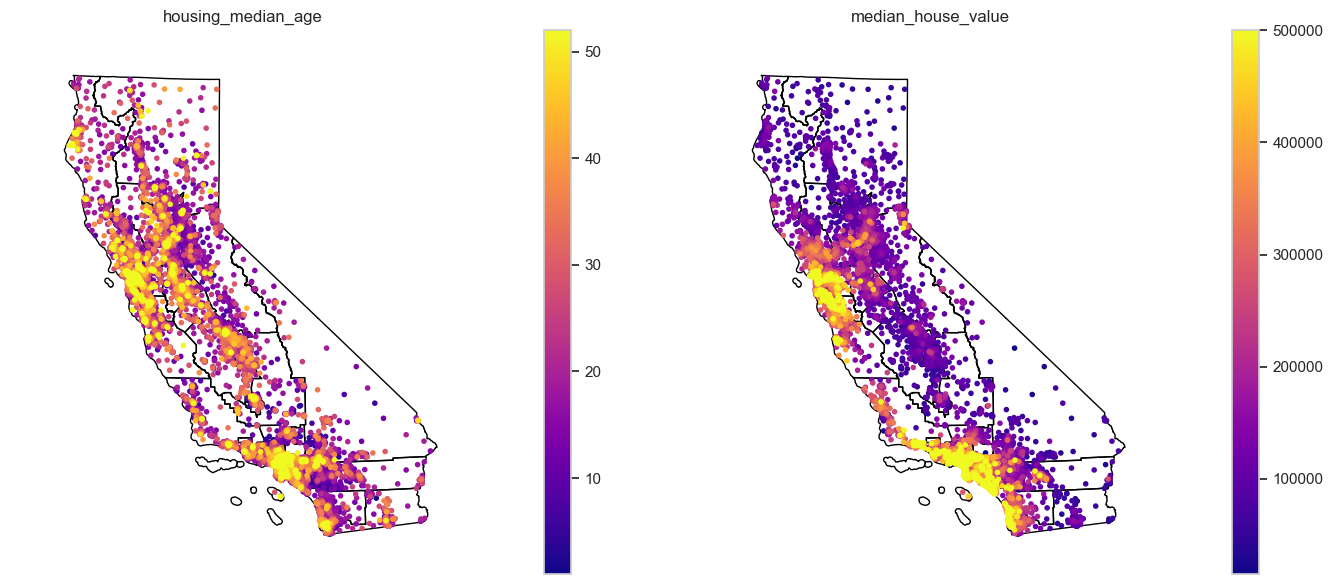

In [13]:
# Call function that plots two geopandas plots 
plotTwo(df2,['population','median_income'])
plotTwo(df2,['housing_median_age','median_house_value'])
del df2['geometry']

Starting here I use a supervised learning method and the scikit-learn library to build models that try to predict median housing value given information about households and houses in certain districts. My steps are commented in each chunk. Out of the 3 regressions I tried, random forest performed the best. Also when I tried fitting a linear regression model with only one variable, I could tell from the plots that the model is underfitting, meaning it doesn't capture the relationship between median housing value and all the other variables. median income alone is insufficient in explaining changes in median housing value. 

In [14]:
## Supervised learning method
# Preprocessing

# Extract input (X) and output (y) data and store them as pandas dataframes
X = df.iloc[:, :-1].values # data pertaining to houses found in a given California district and some summary stats about them based on the 1990 census data
y = df.iloc[:, [-1]].values # median_house_value
print('Input data: ')
print(X)
print('Output data: ')
print(y)

# Fill the missing values with the mean of the respective column
print('Columns with missing data: ')
df[df.isnull().any(axis=1)]

Input data: 
[[-122.23 37.88 41 ... 126 8.3252 'NEAR BAY']
 [-122.22 37.86 21 ... 1138 8.3014 'NEAR BAY']
 [-122.24 37.85 52 ... 177 7.2574 'NEAR BAY']
 ...
 [-121.22 39.43 17 ... 433 1.7 'INLAND']
 [-121.32 39.43 18 ... 349 1.8672 'INLAND']
 [-121.24 39.37 16 ... 530 2.3886 'INLAND']]
Output data: 
[[452600]
 [358500]
 [352100]
 ...
 [ 92300]
 [ 84700]
 [ 89400]]
Columns with missing data: 


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
290,-122.16,37.77,47,1256,NaN,570,218,4.3750,NEAR BAY,161900
341,-122.17,37.75,38,992,NaN,732,259,1.6196,NEAR BAY,85100
538,-122.28,37.78,29,5154,NaN,3741,1273,2.5762,NEAR BAY,173400
563,-122.24,37.75,45,891,NaN,384,146,4.9489,NEAR BAY,247100
696,-122.10,37.69,41,746,NaN,387,161,3.9063,NEAR BAY,178400
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18,3620,NaN,3171,779,3.3409,NEAR OCEAN,220500
20268,-119.18,34.19,19,2393,NaN,1938,762,1.6953,NEAR OCEAN,167400
20372,-118.88,34.17,15,4260,NaN,1701,669,5.1033,<1H OCEAN,410700
20460,-118.75,34.29,17,5512,NaN,2734,814,6.6073,<1H OCEAN,258100


In [15]:
missingValueImputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X[:, :-1] = missingValueImputer.fit_transform(X[:, :-1])
y = missingValueImputer.fit_transform(y)

# Convert categorical column in the dataset to numerical data
X_labelencoder = LabelEncoder()
X[:, -1] = X_labelencoder.fit_transform(X[:, -1])

# Split the data into 80% training dataset and 20% test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

In [16]:
# Standardize train & test sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [17]:
# Linear Regression
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
predictionLinear = linearRegression.predict(X_test) # predict ouput
mseLinear = mean_squared_error(y_test, predictionLinear)

In [18]:
# Decision Tree Regression
DTregressor = DecisionTreeRegressor()
DTregressor.fit(X_train, y_train)
predictionDT = DTregressor.predict(X_test)
mseDT = mean_squared_error(y_test, predictionDT)

In [19]:
# Random Forest Regression
RFregressor = RandomForestRegressor()
RFregressor.fit(X_train, y_train)
predictionRF = RFregressor.predict(X_test)
mseRF = mean_squared_error(y_test, predictionRF)

/var/folders/39/dz75516n3x3cb69nvg9vnwqr0000gn/T/ipykernel_74272/1860589775.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFregressor.fit(X_train, y_train)


In [20]:
print('rmseLinear = ', mseLinear)
print('rmseDT = ', mseDT)
print('rmseRF = ', mseRF)

rmseLinear =  0.3643080104280693
rmseDT =  0.3236658271569147
rmseRF =  0.17767141859886423


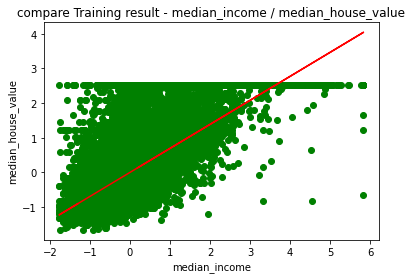

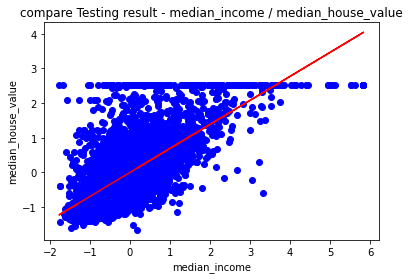

In [19]:
# Linear Regression wiwth one independent variable
# Extract just the median_income column from the independent variables (from X_train and X_test)
X_train_median_income = X_train[: , [7]]
X_test_median_income = X_test[: , [7]]

# Perform LR to predict housing values based on median_income
linearRegression2 = LinearRegression()
linearRegression2.fit(X_train_median_income, y_train)
predictionLinear2 = linearRegression2.predict(X_test_median_income)

# Plot the fitted model for train & test set
# to check if the fitted model satisfies the test data
plt.scatter(X_train_median_income, y_train, color = 'blue')
plt.plot (X_train_median_income, 
          linearRegression2.predict(X_train_median_income), color = 'red')
plt.title ('Compare Training result')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.show()

plt.scatter(X_test_median_income, y_test, color = 'green')
plt.plot (X_train_median_income, 
          linearRegression2.predict(X_train_median_income), color = 'red')
plt.title ('Compare Testing result')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.show()